# OSNet Experiments

This notebook uses OSNet for image classification. OSNet is trained on several image classification datasets, and compared with resnet. All training is done from scratch for fair comparison, so results aren't expected to be competitive with state-of-the-art. Rather, its the relative difference between models trained from scratch that we will be looking at.

Running this notebook requires downloading the datasets and making sure they are in a form that can be handled by `torchvision.datasets.ImageFolder`. We use the following datasets:
- [CUB2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html)
- [Tiny Imagenet](https://www.kaggle.com/c/tiny-imagenet)

### OSNet Architecture

The OSNet we are using has the following architecture:

<table style='width:50%'>
    <tr>
        <th style='text-align:center'>Stage</th>
        <th style='text-align:center'>OSNet</th>
    </tr>
    <tr>
        <td style='text-align:center'>conv1</td>
        <td style='text-align:center'>3x3 conv, stride 2<br>
            3x3 conv x 2<br>
            3x3 max pool, stride 2</td>
    </tr>
    <tr>
        <td style='text-align:center'>conv2</td>
        <td style='text-align:center'>bottleneck x 2<br>
            1x1 conv<br>
            2x2 average pool, stride 2</td>
    </tr>
    <tr>
        <td style='text-align:center'>conv3</td>
        <td style='text-align:center'>bottleneck x 2<br>
            1x1 conv<br>
            2x2 average pool, stride 2</td>
    </tr>
    <tr>
        <td style='text-align:center'>conv4</td>
        <td style='text-align:center'>bottleneck x 2<br>
            1x1 conv<br>
            2x2 average pool, stride 2</td>
    </tr>
    <tr>
        <td style='text-align:center'>conv5</td>
        <td style='text-align:center'>1x1 conv</td>
    </tr>
    <tr>
        <td style='text-align:center'>pool</td>
        <td style='text-align:center'>global average pool</td>
    </tr>
    <tr>
        <td style='text-align:center'>classify</td>
        <td style='text-align:center'>fc(512, n)</td>
    </tr>
</table>

See the paper for architecture details, including the construction of the bottleneck block.

## Setup

This notebook requires the following modules, available through pip:
- pytorch (>= 1.2)
- torchvision (>= 0.3)
- fastprogress

The versions listed are the ones that were used for testing. Other versions may (or may not) work.

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torchvision
import fastprogress
from types import SimpleNamespace
from pathlib import Path
import time
from functools import partial
import osnet

Make sure to choose an appropriate CUDA device number

In [3]:
torch.cuda.set_device(2)

### Data

In [4]:
IMAGENET_STATS = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

ImageFolder = torchvision.datasets.ImageFolder
T = torchvision.transforms

class AddNoise(object):
    def __init__(self, std=0.1):
        self.std = std

    def __call__(self, x):
        x += torch.normal(0.0, float(self.std), x.shape)
        return x

def transforms(train:bool, size=224, stats=IMAGENET_STATS):
    if train:
        tr = T.Compose([
            T.RandomResizedCrop(size),
            T.RandomHorizontalFlip(),
            T.ColorJitter((0.7, 1.2), (0.7, 1.2), (0.7, 1.2)),
            T.ToTensor(),
            AddNoise(0.1/255),
            T.Normalize(*stats)
        ])
    else:
        tr = T.Compose([
            T.Resize([size+32]*2),
            T.CenterCrop([size]*2),
            T.ToTensor(),
            T.Normalize(*stats)
        ])
    return tr

def get_data(root, train='train', val='test', trans='default'):
    root = Path(root)
    if trans == 'default':
        trans = transforms
    data = SimpleNamespace(
        train=ImageFolder(root / train, trans(True)),
        test=ImageFolder(root / val, trans(False)))
    return data

def get_dataloaders(data, bs=32, nw=4):
    L = torch.utils.data.DataLoader
    kwargs = dict(
        batch_size=bs,
        num_workers=nw,
        pin_memory=True
    )
    loaders = SimpleNamespace(
        train=L(data.train, shuffle=True, drop_last=True, **kwargs),
        test=L(data.test, shuffle=False, drop_last=False, **kwargs))
    return loaders

### Training

In [5]:
def tocuda(a, non_blocking=True):
    return [x.cuda(non_blocking=non_blocking) for x in a]

def accuracy(pred, label):
    return pred.argmax(1).eq(label).float().mean()

def fit(data, net, optim, lossfn, epochs=20, schedule=None):
    metrics = SimpleNamespace(train_loss=[], val_loss=[],
                              train_acc=[], val_acc=[])
    mb = fastprogress.master_bar(range(epochs))
    heads = 'epoch time train_loss val_loss train_acc val_acc'.split()
    mb.lines.append(heads)
    for i in mb:
        ct = time.time()
        net.train()
        ll, aa = [], []
        eb = fastprogress.progress_bar(data.train, leave=False, parent=mb)
        for b in eb:
            if schedule: schedule.step()
            imgs, labels = tocuda(b)
            pred = net(imgs)
            loss = lossfn(pred, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
            acc = accuracy(pred, labels).item()
            loss = loss.item()
            ll.append(loss)
            aa.append(acc)
            eb.comment = f'{loss:.5f}'
        metrics.train_loss.append(ll)
        metrics.train_acc.append(aa)
        ll, aa = validate(data, net, optim, lossfn, mb)
        metrics.val_loss.append(ll)
        metrics.val_acc.append(aa)
        ct = time.time() - ct
        stats = [f'{np.mean(getattr(metrics, x)[-1]):.5f}' for x in heads[2:]]
        mb.write([f'{i}', f'{ct:.1f}'] + stats, table=True)
    return metrics

@torch.no_grad()
def validate(data, net, optim, lossfn, mb=None):
    net.eval()
    ll, aa = [], []
    eb = fastprogress.progress_bar(data.test, leave=False, parent=mb)
    for b in eb:
        imgs, labels = tocuda(b)
        pred = net(imgs)
        loss = lossfn(pred, labels)
        aa.append(accuracy(pred, labels).item())
        ll.append(loss.item())
    return ll, aa

### Learning rate schedule

We're using a cosine anealing learning rate schedule with a linear warm up.

In [6]:
class LinCosOneCycleLR(object):
    def __init__(self, optim, iters, min=1e-5, peak=0.02):
        self.optim = optim
        self.min = min
        self.max = optim.param_groups[-1]['lr']
        self.peak_p = peak
        
        self.iters = iters
        self.peak = int(self.iters * self.peak_p)
        self.up = (self.max- self.min) / self.peak
        self.freq = math.pi / (self.iters - self.peak)
        self.scale = 0.5 * (self.max - self.min)
        self.i = 0

    def __repr__(self):
        return (f'{self.__class__.__name__}(min={self.min}, '
                f'max={self.max}, peak={self.peak_p})')

    def __str__(self): return self.__repr__()

    def step(self, target=None):
        i, peak = self.i, self.peak
        if i <= peak:
            lr = self.min + i * self.up
        else:
            lr = self.min + self.scale*(math.cos((i-peak)*self.freq)+1)
        self.i = i + 1
        if target is None:
            for pg in self.optim.param_groups:
                pg['lr'] = lr
        else:
            target.append(lr)
    
    def get_lrs(self):
        lrs = []
        for i in range(self.iters):
            self.step(lrs)
        return lrs

The learning rate schedule looks like this:

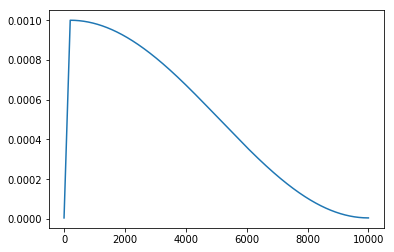

In [8]:
optim = torch.optim.Adam([torch.rand(10, requires_grad=True)], lr=1e-3)
sched = LinCosOneCycleLR(optim, 50*200, min=5e-6, peak=1/50)
lrs = sched.get_lrs()
plot(lrs)

## Tiny Imagenet Classification

Tiny Imagenet is a scaled down version of the iconic dataset. It contains 200 of the original 1000 classes. There are 500 training images per class, and the images have been downsized to 64x64.

In [9]:
bs = 128
nw = 8

In [10]:
data = get_data('/mv_users/connor/data/tiny-imagenet', val='val',
                trans=partial(transforms, size=64))
dloaders = get_dataloaders(data, bs, nw)

### Train resnet18

In [11]:
epochs = 80
net = torchvision.models.resnet18(pretrained=False)
net.fc = torch.nn.Linear(512, 200)
net.cuda()
print('Parameters: ', sum([x.nelement() for x in net.parameters()]))
optim = torch.optim.Adam(net.parameters(), lr=3e-3)
lossfn = torch.nn.CrossEntropyLoss()
sched = LinCosOneCycleLR(optim, epochs*len(dloaders.train), min=5e-6, peak=1/50)

resnet18_imgnet_metrics = fit(dloaders, net, optim, lossfn, epochs=epochs, schedule=sched)

Parameters:  11279112


epoch,time,train_loss,val_loss,train_acc,val_acc
0,29.4,4.85635,4.53863,0.04291,0.06408
1,29.7,4.31992,4.11500,0.09826,0.12085
2,30.0,3.96906,3.61956,0.14704,0.19591
3,30.8,3.73976,3.58792,0.18271,0.20362
4,32.1,3.55415,3.39379,0.21587,0.24100
5,32.4,3.42236,3.18564,0.23504,0.27097
6,32.5,3.29445,3.07970,0.25896,0.28946
7,32.5,3.17755,3.09272,0.28172,0.29104
8,32.4,3.09187,3.14651,0.29658,0.29361
9,32.5,3.00465,2.86311,0.31381,0.33792


### Train OSNet

In [12]:
epochs = 80
net = osnet.OSNet(200)
print('Parameters: ', sum([x.nelement() for x in net.parameters()]))
net.cuda()
optim = torch.optim.Adam(net.parameters(), lr=3e-3)
lossfn = torch.nn.CrossEntropyLoss()
sched = LinCosOneCycleLR(optim, epochs*len(dloaders.train), min=5e-6, peak=1/50)

osnet_imgnet_metrics = fit(dloaders, net, optim, lossfn, epochs=epochs, schedule=sched)

Parameters:  2050357


epoch,time,train_loss,val_loss,train_acc,val_acc
0,106.1,4.97305,4.74497,0.03145,0.05053
1,105.5,4.49368,4.23349,0.07500,0.10245
2,107.1,4.16295,4.05689,0.11356,0.11887
3,105.6,3.96337,3.82036,0.14114,0.15022
4,106.6,3.81182,3.57355,0.16433,0.19274
5,105.1,3.68426,3.62393,0.18498,0.19531
6,106.9,3.58113,3.39378,0.20323,0.23279
7,106.2,3.47931,3.37271,0.21916,0.23813
8,105.6,3.38752,3.18555,0.23409,0.26671
9,105.0,3.31032,3.22534,0.24823,0.25821


### Compare Results

Text(0, 0.5, 'loss')

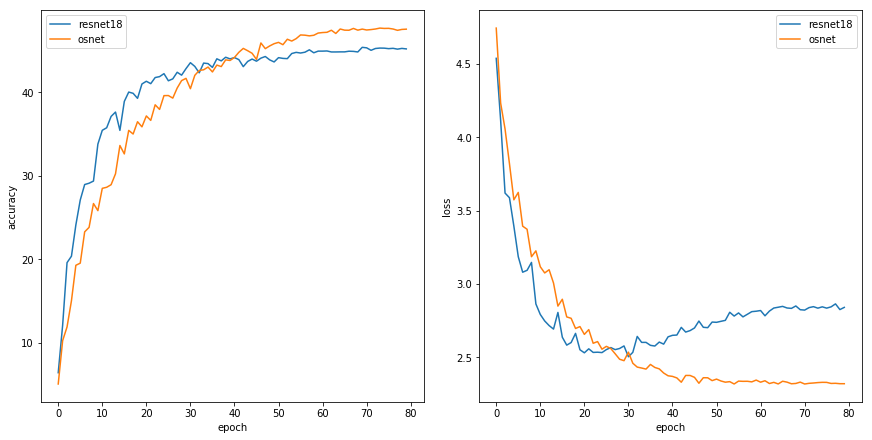

In [13]:
fig, ax = subplots(1, 2, figsize=(12, 6), constrained_layout=True)

ax[0].plot(np.mean(resnet18_imgnet_metrics.val_acc, 1)*100, label='resnet18')
ax[0].plot(np.mean(osnet_imgnet_metrics.val_acc, 1)*100, label='osnet')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')

ax[1].plot(np.mean(resnet18_imgnet_metrics.val_loss, 1), label='resnet18')
ax[1].plot(np.mean(osnet_imgnet_metrics.val_loss, 1), label='osnet')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

## Fine-grained Classification with CUB2011

In [14]:
bs = 32
nw = 4

In [15]:
data = get_data('/mv_users/connor/data/cub2011')
dloaders = get_dataloaders(data, bs, nw)

### Train resnet18

In [16]:
epochs = 80
net = torchvision.models.resnet18(pretrained=False)
net.fc = torch.nn.Linear(512, 200)
net.cuda()
print('Parameters: ', sum([x.nelement() for x in net.parameters()]))
optim = torch.optim.Adam(net.parameters(), lr=2e-3)
lossfn = torch.nn.CrossEntropyLoss()
sched = LinCosOneCycleLR(optim, epochs*len(dloaders.train), min=5e-6, peak=1/50)

resnet18_cub_metrics = fit(dloaders, net, optim, lossfn, epochs=epochs, schedule=sched)

Parameters:  11279112


epoch,time,train_loss,val_loss,train_acc,val_acc
0,68.4,5.34440,5.59503,0.01036,0.01374
1,63.9,5.15248,5.25450,0.01420,0.01528
2,61.4,5.02308,4.91964,0.01755,0.02249
3,62.4,4.90876,4.72743,0.02005,0.03949
4,56.6,4.81505,4.64350,0.02590,0.04258
5,58.8,4.73006,4.54959,0.03643,0.04378
6,57.9,4.64841,4.41007,0.03894,0.05563
7,60.3,4.53327,4.40228,0.04746,0.06044
8,59.4,4.44651,4.23929,0.06116,0.07074
9,59.2,4.35863,4.20319,0.06384,0.08328


### Train OSNet

In [17]:
epochs = 80
net = osnet.OSNet(200)
print('Parameters: ', sum([x.nelement() for x in net.parameters()]))
net.cuda()
optim = torch.optim.Adam(net.parameters(), lr=2e-3)
lossfn = torch.nn.CrossEntropyLoss()
sched = LinCosOneCycleLR(optim, epochs*len(dloaders.train), min=5e-6, peak=1/50)

osnet_cub_metrics = fit(dloaders, net, optim, lossfn, epochs=epochs, schedule=sched)

Parameters:  2050357


epoch,time,train_loss,val_loss,train_acc,val_acc
0,59.6,5.27880,5.13055,0.00852,0.01906
1,59.8,5.03533,5.05927,0.01822,0.02335
2,59.9,4.80380,4.52603,0.02841,0.04688
3,59.8,4.59222,4.56369,0.04144,0.04979
4,59.7,4.44566,4.26935,0.05465,0.07109
5,59.4,4.32932,4.21684,0.06400,0.06696
6,58.2,4.20853,4.02540,0.07203,0.09100
7,59.3,4.08657,3.84167,0.08824,0.11607
8,58.5,3.95612,3.90910,0.10561,0.10731
9,58.8,3.87326,3.76441,0.12149,0.14423


### Compare Results

Text(0, 0.5, 'loss')

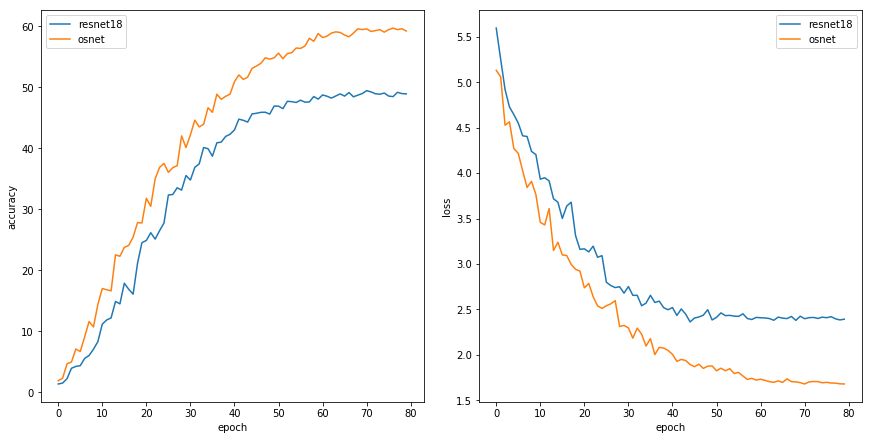

In [18]:
fig, ax = subplots(1, 2, figsize=(12, 6), constrained_layout=True)

ax[0].plot(np.mean(resnet18_cub_metrics.val_acc, 1)*100, label='resnet18')
ax[0].plot(np.mean(osnet_cub_metrics.val_acc, 1)*100, label='osnet')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')

ax[1].plot(np.mean(resnet18_cub_metrics.val_loss, 1), label='resnet18')
ax[1].plot(np.mean(osnet_cub_metrics.val_loss, 1), label='osnet')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')

## Conclusions

The OSNet solidly outperforms Resnet18 when trained from scratch, despite having less than 20\% of the number of parameters -- particularly on the smaller fine-grained CUB dataset, where its final test accuracy was more than 10\% higher. The downside is that it is slower to train (significantly slower on Tiny ImageNet). It's also unclear how fair the comparison is, because while Resnet18 has many more parameters, OSNet has a larger effective depth if you consider the deepest path through each bottleneck block. It would be interesting to do the comparison to a deeper network like Resnet50.